In [13]:
%load_ext autoreload
%autoreload 2
from src.models.representation.vae import *
from src.models.representation.vae.vae import RecurrentVaeWithTeacherForcing
from src.models.representation.vae.decoder.recurrent_decoder import LSTMVaeDecoderWithTeacherForcing
from src.dataloader.dataset import PianoRollMidiDataset



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pickle

import torch

dataset: PianoRollMidiDataset = pickle.load(open("data/preprocessed_note_events.pkl", "rb"))



In [15]:
from torch.utils.data import DataLoader
encoder = LSTMVaeEncoder(
    4, 
    64,
    64,
    2
)
decoder = LSTMVaeDecoderWithTeacherForcing(
    64, 
    64,
    2,
    4,
    4,
    teacher_forcing_ratio=0.5,
)

vae = RecurrentVaeWithTeacherForcing(encoder, decoder).cuda()


midi_dataloader = DataLoader(
    dataset,
    batch_size=32,
    pin_memory=True,
    num_workers=4,
    shuffle=True,
)


t = next(iter(midi_dataloader))


In [16]:
t.shape

torch.Size([32, 128, 4])

In [17]:
vae(t.cuda())

(tensor([[[-0.0701,  0.0225, -0.0031, -0.0840],
          [-0.0272,  0.0741, -0.0084, -0.0993],
          [ 0.0019,  0.1129, -0.0102, -0.1255],
          ...,
          [ 0.0334,  0.1613, -0.0189, -0.1300],
          [ 0.0331,  0.1613, -0.0198, -0.1307],
          [ 0.0355,  0.1611, -0.0084, -0.1187]],
 
         [[ 0.0910,  0.2189, -0.1193, -0.1922],
          [ 0.0493,  0.1718, -0.0748, -0.1672],
          [ 0.0317,  0.1597, -0.0530, -0.1532],
          ...,
          [ 0.0325,  0.1612, -0.0163, -0.1263],
          [ 0.0323,  0.1614, -0.0183, -0.1283],
          [ 0.0330,  0.1621, -0.0184, -0.1297]],
 
         [[ 0.0995,  0.0367,  0.1455,  0.1473],
          [ 0.0736,  0.1137,  0.0779,  0.0569],
          [ 0.0434,  0.1416,  0.0297, -0.0249],
          ...,
          [ 0.0331,  0.1617, -0.0154, -0.1256],
          [ 0.0327,  0.1613, -0.0171, -0.1268],
          [ 0.0328,  0.1616, -0.0168, -0.1269]],
 
         ...,
 
         [[-0.0074,  0.1749, -0.1827, -0.1264],
          [ 0.0371

In [18]:
import torch

optimizer = torch.optim.Adam(
    vae.parameters(),
    lr=5*1e-4,
)

loss_fn = VaeLoss(reduction="mean")

trainer = VaeTrainer(
    vae,
    optimizer,
    loss_fn,
    "test/simple_vae",
    10
)

print(t.shape)
trainer.train(midi_dataloader, epochs=10)
trainer.save("test/simple_vae_final.pth")

torch.Size([32, 128, 4])
Epoch [1/10], Loss: 0.7820, Run: test/simple_vae
Epoch [1/10], Loss: 0.6109, Run: test/simple_vae
Epoch [1/10], Loss: 0.4980, Run: test/simple_vae
Epoch [1/10], Loss: 0.4344, Run: test/simple_vae
Epoch [1/10], Loss: 0.3924, Run: test/simple_vae
Epoch [1/10], Loss: 0.3668, Run: test/simple_vae
Epoch [1/10], Loss: 0.3457, Run: test/simple_vae
Epoch [1/10], Loss: 0.3302, Run: test/simple_vae
Epoch [1/10], Loss: 0.3158, Run: test/simple_vae
Epoch [1/10], Loss: 0.3009, Run: test/simple_vae
Epoch [1/10], Loss: 0.2901, Run: test/simple_vae
Epoch [1/10], Loss: 0.2819, Run: test/simple_vae
Epoch [1/10], Loss: 0.2757, Run: test/simple_vae
Epoch [1/10], Loss: 0.2700, Run: test/simple_vae
Epoch [1/10], Loss: 0.2645, Run: test/simple_vae
Epoch [1/10], Loss: 0.2570, Run: test/simple_vae
Epoch [1/10], Loss: 0.2518, Run: test/simple_vae
Epoch [1/10], Loss: 0.2477, Run: test/simple_vae
Epoch [1/10], Loss: 0.2452, Run: test/simple_vae
Epoch [1/10], Loss: 0.2414, Run: test/simple

KeyboardInterrupt: 

In [19]:
vae.encoder(t[0].unsqueeze(1).cuda())



(tensor([[ 0.0166, -0.0400, -0.0158,  ...,  0.0327, -0.0041,  0.0707],
         [ 0.0167, -0.0400, -0.0158,  ...,  0.0326, -0.0040,  0.0707],
         [ 0.0167, -0.0400, -0.0157,  ...,  0.0326, -0.0040,  0.0708],
         ...,
         [ 0.0192, -0.0402, -0.0166,  ...,  0.0326, -0.0051,  0.0704],
         [ 0.0192, -0.0402, -0.0165,  ...,  0.0326, -0.0050,  0.0705],
         [ 0.0185, -0.0401, -0.0162,  ...,  0.0332, -0.0052,  0.0705]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 0.0768, -0.0362, -0.0277,  ...,  0.0233, -0.0046, -0.0561],
         [ 0.0768, -0.0360, -0.0277,  ...,  0.0232, -0.0044, -0.0562],
         [ 0.0768, -0.0361, -0.0276,  ...,  0.0232, -0.0045, -0.0561],
         ...,
         [ 0.0761, -0.0371, -0.0284,  ...,  0.0245, -0.0038, -0.0567],
         [ 0.0762, -0.0372, -0.0284,  ...,  0.0245, -0.0038, -0.0567],
         [ 0.0768, -0.0371, -0.0284,  ...,  0.0240, -0.0043, -0.0568]],
        device='cuda:0', grad_fn=<AddmmBackward0>))

100%|██████████| 10/10 [00:00<00:00, 10.73it/s]


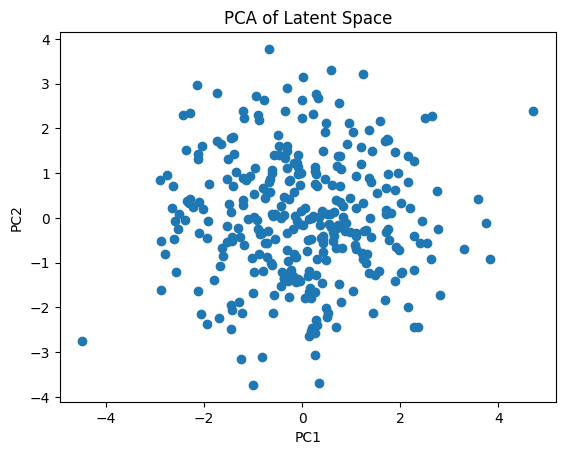

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm


@torch.inference_mode
def plot_pca(samples: list[tuple[torch.Tensor, torch.Tensor]]):
    all_latents = []
    for mu, logvar in samples:
        reparam = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
        all_latents.append(reparam.cpu().numpy())

    all_latents = np.concatenate(all_latents, axis=0)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_latents)

    plt.scatter(reduced[:, 0], reduced[:, 1])
    plt.title("PCA of Latent Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

vae.eval()
eg_samples = []
for i in tqdm(range(10)):
    t = next(iter(midi_dataloader))
    mu, logvar = vae.encoder(t.cuda())
    eg_samples.append((mu, logvar))

plot_pca(eg_samples)

In [39]:
import pretty_midi

noise = torch.randn(1, 64).cuda()

@torch.inference_mode
def sampler(noise, sqe_length, vae: RecurrentVae):
    """
    Sample from the VAE using the provided noise.
    """
    vae.eval()
    # Encode the noise
    # Decode to get the generated sequence
    generated_sequence = vae.decoder(noise, seq_length=sqe_length)
    return generated_sequence
    
eg_track = sampler(noise, 128, vae)

In [47]:
def print_track_stats(track: torch.Tensor):
    """
    Print statistics of the track.
    """
    pitches = track[:, 0].cpu().numpy()
    velocities = track[:, 1].cpu().numpy()
    time = track[:, 2].cpu().numpy()
    duration = track[:, 3].cpu().numpy()
    pitches = pitches*127  # Scale pitches
    velocities = velocities*127  # Scale velocities
    print(f"Track Length: {len(track)}")
    print(f"Unique Pitches: {np.unique(pitches).size}")
    print(f"Unique Velocities: {np.unique(velocities).size}")
    print(f"max Pitch: {np.max(pitches)}")
    print(f"min Pitch: {np.min(pitches)}")
    print(f"max Velocity: {np.max(velocities)}")
    print(f"min Velocity: {np.min(velocities)}")
    print(f"Mean Pitch: {np.mean(pitches)}")
    print(f"Mean Velocity: {np.mean(velocities)}")
    duration_total = 0
    for i in range(1, len(duration)):
        duration_total += time[i] + duration[i]
    print(f"Total Duration: {duration_total}")
    
    

print_track_stats(eg_track[0])


Track Length: 128
Unique Pitches: 128
Unique Velocities: 128
max Pitch: 70.0208740234375
min Pitch: 63.26213455200195
max Velocity: 73.4431381225586
min Velocity: 61.085018157958984
Mean Pitch: 64.60739135742188
Mean Velocity: 69.83796691894531
Total Duration: 14.272855758666992


In [ ]:
print_track_stats(t)

Track Length: 32
Unique Pitches: 102
Unique Velocities: 103
max Pitch: 143.20571899414062
min Pitch: -138.07943725585938
max Velocity: 153.62368774414062
min Velocity: -153.62368774414062
Mean Pitch: 38.50440216064453
Mean Velocity: 37.090576171875
Total Duration: [ 31.338581  36.74803  -16.93099   27.942707]


In [ ]:
print_track_stats(vae(t.cuda())[0])

Track shape: torch.Size([16, 640, 60]) 
Track min: -0.24507708847522736 | scaled min: 0.0
Track max: 0.9801698923110962 | scaled max: 124.48157501220703
Track mean: 0.04459753260016441 | scaled mean: 6.366756439208984
Track std: 0.1512681245803833 | scaled std: 18.926008224487305


In [38]:
import pretty_midi

@torch.inference_mode
def note_events_to_pretty_midi(note_array, path="eg.mid", default_program=0):
    note_array = note_array.detach().cpu().numpy()
    #scale pitches and velocities
    note_array[:, 0] *= 127
    note_array[:, 1] *= 127
    # clamp pitches and velocities
    note_array[:, 0] = np.clip(note_array[:, 0], 0, 127)
    note_array[:, 1] = np.clip(note_array[:, 1], 0, 127)
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=default_program)

    current_time = 0.0
    print(note_array.shape)
    for row in note_array:
        pitch, velocity, delta, duration = row
        current_time += delta
        start = current_time
        end = start + duration

        note = pretty_midi.Note(
            velocity=int(velocity),
            pitch=int(pitch),
            start=start,
            end=end
        )
        instrument.notes.append(note)

    pm.instruments.append(instrument)
    pm.write(path)


note_events_to_pretty_midi(eg_track[0], path="eg.mid")

(128, 4)


In [ ]:

track_reco, _, _ = vae(t.cuda())
note_events_to_pretty_midi(track_reco[0], path="reco.mid")

In [ ]:
track_true = t[0]
note_events_to_pretty_midi(track_true, path="true.mid")

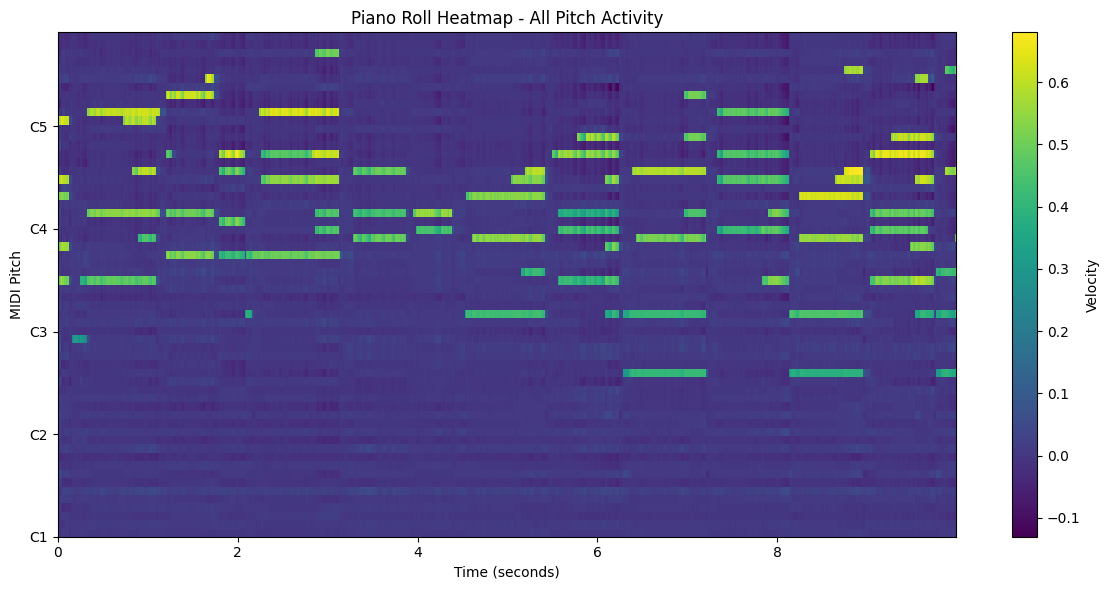

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy import ndimage

def plot_pitch_changes(piano_roll, fs=64, pitch_range=(24, 84), method='heatmap'):
    """
    Plot pitch changes from piano roll data in various ways.
    
    Args:
        piano_roll: Piano roll tensor/array [time, pitch]
        fs: Sample rate (frames per second)
        pitch_range: (min_pitch, max_pitch) MIDI note numbers
        method: 'heatmap', 'dominant', 'centroid', 'active_notes', or 'all'
    """
    if isinstance(piano_roll, torch.Tensor):
        piano_roll = piano_roll.detach().cpu().numpy()
    
    time_steps, pitch_count = piano_roll.shape
    time_axis = np.arange(time_steps) / fs
    pitch_axis = np.arange(pitch_range[0], pitch_range[0] + pitch_count)
    
    if method == 'heatmap' or method == 'all':
        plot_piano_roll_heatmap(piano_roll, time_axis, pitch_axis)
    
    if method == 'dominant' or method == 'all':
        plot_dominant_pitch(piano_roll, time_axis, pitch_axis)
    
    if method == 'centroid' or method == 'all':
        plot_pitch_centroid(piano_roll, time_axis, pitch_axis)
    
    if method == 'active_notes' or method == 'all':
        plot_active_notes(piano_roll, time_axis, pitch_axis)
    
    plt.tight_layout()
    plt.show()

def plot_piano_roll_heatmap(piano_roll, time_axis, pitch_axis):
    """Plot piano roll as a heatmap showing all pitch activity over time."""
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll.T, aspect='auto', origin='lower', 
               extent=[time_axis[0], time_axis[-1], pitch_axis[0], pitch_axis[-1]],
               cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Velocity')
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('Piano Roll Heatmap - All Pitch Activity')
    
    # Add note names for reference
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave_ticks = [i for i in range(int(pitch_axis[0]), int(pitch_axis[-1]), 12)]
    octave_labels = [f"{note_names[tick % 12]}{tick // 12 - 1}" for tick in octave_ticks]
    plt.yticks(octave_ticks, octave_labels)

def plot_dominant_pitch(piano_roll, time_axis, pitch_axis):
    """Plot the dominant (loudest) pitch at each time step."""
    dominant_pitches = []
    dominant_velocities = []
    
    for t in range(len(time_axis)):
        frame = piano_roll[t, :]
        if np.max(frame) > 0:
            dominant_idx = np.argmax(frame)
            dominant_pitches.append(pitch_axis[dominant_idx])
            dominant_velocities.append(frame[dominant_idx])
        else:
            dominant_pitches.append(np.nan)
            dominant_velocities.append(0)
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, dominant_pitches, 'b-', linewidth=2, alpha=0.7)
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('Dominant Pitch Over Time')
    plt.grid(True, alpha=0.3)

def plot_pitch_centroid(piano_roll, time_axis, pitch_axis):
    """Plot the pitch centroid (weighted average pitch) over time."""
    centroids = []
    
    for t in range(len(time_axis)):
        frame = piano_roll[t, :]
        if np.sum(frame) > 0:
            # Weighted average pitch
            centroid = np.sum(pitch_axis * frame) / np.sum(frame)
            centroids.append(centroid)
        else:
            centroids.append(np.nan)
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, centroids, 'r-', linewidth=2, alpha=0.7)
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('Pitch Centroid Over Time (Weighted Average)')
    plt.grid(True, alpha=0.3)

def plot_active_notes(piano_roll, time_axis, pitch_axis, threshold=0.1):
    """Plot all active notes as separate lines over time."""
    plt.figure(figsize=(12, 8))
    
    # Normalize piano roll for better visualization
    piano_roll_norm = piano_roll / np.max(piano_roll) if np.max(piano_roll) > 0 else piano_roll
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(pitch_axis)))
    
    for pitch_idx, pitch in enumerate(pitch_axis):
        activity = piano_roll_norm[:, pitch_idx]
        
        # Only plot pitches that have some activity
        if np.max(activity) > threshold:
            # Create y-values that show note activity
            y_values = np.where(activity > threshold, pitch, np.nan)
            plt.plot(time_axis, y_values, 'o-', color=colors[pitch_idx % len(colors)], 
                    markersize=3, alpha=0.7, linewidth=1)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('Active Notes Over Time')
    plt.grid(True, alpha=0.3)

def analyze_pitch_transitions(piano_roll, fs=64, pitch_range=(24, 84)):
    """Analyze pitch transitions and movement patterns."""
    if isinstance(piano_roll, torch.Tensor):
        piano_roll = piano_roll.detach().cpu().numpy()
    
    time_steps, pitch_count = piano_roll.shape
    pitch_axis = np.arange(pitch_range[0], pitch_range[0] + pitch_count)
    
    # Calculate pitch centroids
    centroids = []
    for t in range(time_steps):
        frame = piano_roll[t, :]
        if np.sum(frame) > 0:
            centroid = np.sum(pitch_axis * frame) / np.sum(frame)
            centroids.append(centroid)
        else:
            centroids.append(np.nan)
    
    centroids = np.array(centroids)
    
    # Calculate pitch changes (derivatives)
    valid_mask = ~np.isnan(centroids)
    pitch_changes = np.diff(centroids[valid_mask])
    
    # Statistics
    print("Pitch Movement Analysis:")
    print(f"Average pitch: {np.nanmean(centroids):.2f}")
    print(f"Pitch range: {np.nanmin(centroids):.2f} - {np.nanmax(centroids):.2f}")
    print(f"Average pitch change: {np.mean(np.abs(pitch_changes)):.2f} semitones")
    print(f"Max upward jump: {np.max(pitch_changes):.2f} semitones")
    print(f"Max downward jump: {np.min(pitch_changes):.2f} semitones")
    
    # Plot pitch change histogram
    plt.figure(figsize=(10, 6))
    plt.hist(pitch_changes, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Pitch Change (semitones)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pitch Changes')
    plt.grid(True, alpha=0.3)
    plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='No change')
    plt.legend()
    plt.show()
    
    return centroids, pitch_changes

plot_pitch_changes(track_reco[0])
# centroids, changes = analyze_pitch_transitions(track_reco[0])


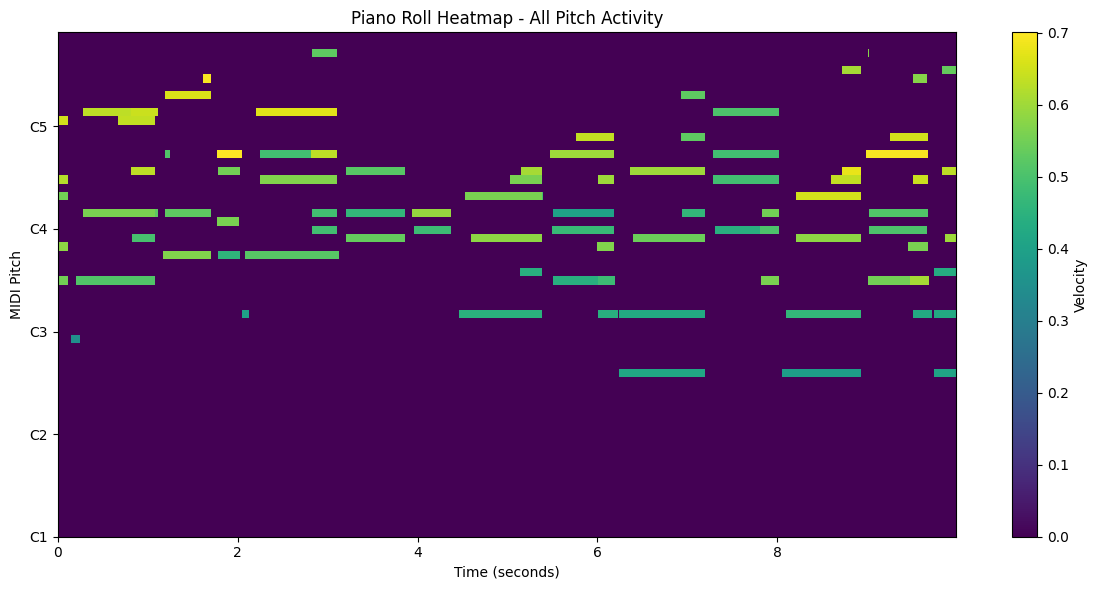

In [ ]:
plot_pitch_changes(track_true)
